In [1]:
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# %  [par] = Mass (kg)	Elasticity (N/m)	Viscosity (Ns/m)
# %(Hayward 2018)  
# par(1,:)=[0.1*1e-3	1*1e3	1];	%mass-spring-damper system
# %(Wiertlewski and Hayward 2012a)
# % ranging...
# par(2,:)=[0.11*1e-3	0.6*1e3	0.75];	%tangential elastic model
# par(3,:)=[0.23*1e-3	2*1e3	2.38];	%tangential elastic model
# %(Summers et al. 2005)
# par(4,:)=[0.01*1e-3	0.1*1e3	0.1];	%mass-spring-damper system
# %(Nakazawa, Ikeura, and Inooka 2000), (Okamoto, Konyo, and Tadokoro 2011)
# par(5,:)=[1*1e-3	0.4*1e3	2];		%mass-spring-damper system

# soa = {'Hayward2018','Wiertlewski2012a','Wiertlewski2012b','Summers2005','Nakazawa2000'};



model_parameters = {
    "Hayward2018": {
                "mass": 0.1*1e-3 ,
                "elasticity":  1*1e3,
                "viscosity":  1 ,
                },
    "Wiertlewski2012a": {
                "mass": 0.11e-3 ,
                "elasticity":  0.6*1e3,
                "viscosity":  0.75 ,
                },
    "Wiertlewski2012b": {
                "mass":  0.23*1e-3,
                "elasticity": 2*1e3 ,
                "viscosity": 2.38  ,
                },
    "Summers2005": {
                "mass": 0.01*1e-3 ,
                "elasticity": 0.1*1e3 ,
                "viscosity":  0.1 ,
                },
    "Nakazawa2000": {
                "mass": 1*1e-3 ,
                "elasticity": 0.4*1e3 ,
                "viscosity": 2  ,
                },
}

model_parameters

{'Hayward2018': {'mass': 0.0001, 'elasticity': 1000.0, 'viscosity': 1},
 'Wiertlewski2012a': {'mass': 0.00011, 'elasticity': 600.0, 'viscosity': 0.75},
 'Wiertlewski2012b': {'mass': 0.00023,
  'elasticity': 2000.0,
  'viscosity': 2.38},
 'Summers2005': {'mass': 1e-05, 'elasticity': 100.0, 'viscosity': 0.1},
 'Nakazawa2000': {'mass': 0.001, 'elasticity': 400.0, 'viscosity': 2}}

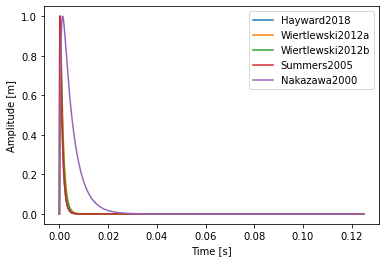

In [3]:
fs_audio = 8192
N_easing = 1024
# N_easing = 128
t = np.linspace(0, N_easing/fs_audio, N_easing)
for model in model_parameters:
    mass = model_parameters[model]["mass"]
    elasticity = model_parameters[model]["elasticity"]
    viscosity = model_parameters[model]["viscosity"]
    
    eta = viscosity/(2*np.sqrt(mass*elasticity))
    wn = np.sqrt(elasticity/mass)
    fn = wn/(2*np.pi)
    
    
    A = 1/(2*wn*np.sqrt(np.power(eta,2)-1))
    l1 = -eta*wn+np.sqrt(np.power(eta,2)-1)*wn
    l2 = -eta*wn-np.sqrt(np.power(eta,2)-1)*wn
    
    G = A*(np.exp(l1*t)-np.exp(l2*t))
    
#     plt.plot(t,G, label=model)
    plt.plot(t,G/np.max(G), label=model)
#     print (model, eta, fn)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [m]')

plt.legend()

In [4]:
from scipy import signal
def generate_impulse_train(velocity, N_frame, fs, delay=0):
    """
    Generates an impulse train respective of the velocity, in frame of size N_frame, sampled at fs
    counting a delay number of samples (float for average finger_velocity) since the last impulse.
    """
    n_impulse_velocity_period = (1/velocity)*fs

    idx = np.array([])

    idx = np.arange(-delay, N_frame, n_impulse_velocity_period)

    
    idx = idx[np.where(idx>=0)]

    if idx.size == 0:
        delay = delay+N_frame
        impulse = np.zeros(N_frame)
    else:
        delay = N_frame-idx[-1]
        idx = np.array(idx).astype(np.int)
#         idx = tuple(idx)
        
        impulse = signal.unit_impulse(N_frame, [i for i in idx])
    
    return (impulse, delay)    
    
    

def calculate_model_impulse(model, t):

    for model in model_parameters:
        mass = model_parameters[model]["mass"]
        elasticity = model_parameters[model]["elasticity"]
        viscosity = model_parameters[model]["viscosity"]

        eta = viscosity/(2*np.sqrt(mass*elasticity))
        wn = np.sqrt(elasticity/mass)
        fn = wn/(2*np.pi)


        A = 1/(2*wn*np.sqrt(np.power(eta,2)-1))
        l1 = -eta*wn+np.sqrt(np.power(eta,2)-1)*wn
        l2 = -eta*wn-np.sqrt(np.power(eta,2)-1)*wn

        G = A*(np.exp(l1*t)-np.exp(l2*t))
        
        return G

    
    
fs_audio = 8192
N_easing = 1024
# N_easing = 128
t = np.linspace(0, N_easing/fs_audio, N_easing)
impulse_Nakazawa2000 = calculate_model_impulse('Nakazawa2000',t)



..\Code\texture_vibration_generator\textures\ABS\MT-11020\MT-11020_spectrum.txt


ValueError: x and y must have same first dimension, but have shapes (34816,) and (69632,)

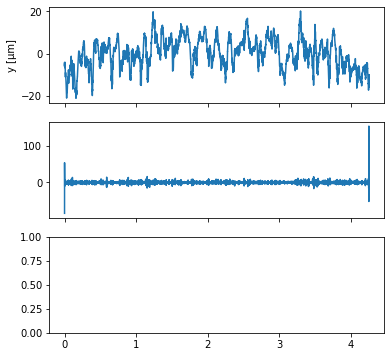

In [25]:
import os
import json
import IPython.display as ipd

velocity = 4 #mm/s


textures_dictionary = dict()

path_textures = "..\\Code\\texture_vibration_generator"
json_filename = os.path.join(path_textures, "textures", "textures.json")
with open(json_filename) as json_file:
    textures_dictionary = json.load(json_file)

texture_names = list(textures_dictionary.keys())
selected_texture = texture_names[0]

texture_file = textures_dictionary[selected_texture]
texture_filename = os.path.join(path_textures, texture_file)
print(texture_filename)
x, profile = np.loadtxt(texture_filename, delimiter=',', unpack=True)

transient_x = x/velocity
profile = profile*1e-6

N_texture = len(profile)
k_spatial = N_texture/np.ptp(x)

N_resample = np.int(fs_audio/(k_spatial*velocity)*N_texture)

profile,transient_x = signal.resample(profile, N_resample, transient_x)

d_profile = np.gradient(profile, transient_x)
d2_profile = np.gradient(d_profile, transient_x)




impulse_train, delay = generate_impulse_train(velocity, len(profile) , fs_audio, delay=0)

# plt.plot( transient_x, impulse_train)

impulse_model = calculate_model_impulse('Nakazawa2000',t)


impulse = np.convolve(impulse_train, impulse_model, mode='same')


conv_impulse = np.convolve(d2_profile, impulse, mode='same')

fig, axes = plt.subplots(3,1, figsize=(6,6), sharex=True)

plt.sca(axes[0])
plt.plot(transient_x, profile/1e-6)

# plt.xlabel('x [mm]')
plt.ylabel('y [µm]')


# plt.sca(axes[1])
# plt.plot(x, d_profile)

# # plt.xlabel('x [mm]')
# plt.ylabel('y\' [µm]')


plt.sca(axes[1])
plt.plot(transient_x, d2_profile)

plt.plot( transient_x, impulse/np.max(impulse)*np.max(d2_profile))


# plt.xlabel('x [mm]')
plt.ylabel('a [m/s$^2$]')




plt.sca(axes[2])
plt.plot(transient_x, conv_impulse)

plt.xlabel('t [s]')
plt.ylabel('Convolution [µm]')




ipd.Audio(conv_impulse, rate=fs_audio) # load a local WAV file

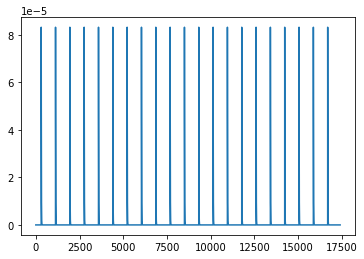

In [16]:
plt.plot(impulse)